# **2702236156 - Veron Fujimori**

## 1. Import Required Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

## 2. Data Loading and Initial Exploration

In [65]:
df = pd.read_csv('./Dataset/train.csv')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [66]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB
None


In [67]:
print("Dataset Description:")
df.describe()

Dataset Description:


,id,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000,90615.000000
mean,45307.000000,0.517098,0.401679,0.135464,0.789035,0.340778,0.169422,0.225898,9.696794
std,26158.441658,0.118217,0.098026,0.038008,0.457671,0.204428,0.100909,0.130203,3.176221
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,22653.500000,0.445000,0.345000,0.110000,0.419000,0.177500,0.086500,0.120000,8.000000
50%,45307.000000,0.545000,0.425000,0.140000,0.799500,0.330000,0.166000,0.225000,9.000000
75%,67960.500000,0.600000,0.470000,0.160000,1.067500,0.463000,0.232500,0.305000,11.000000
max,90614.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [68]:
print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found!")

Missing Values:
No missing values found!


In [69]:
print("Data Types:")
print(df.dtypes)

Data Types:
id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object


In [70]:
print("Unique values in categorical columns:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

Unique values in categorical columns:
Sex: ['F' 'I' 'M']


In [72]:
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    print("\nFirst few duplicate rows:")
    print(df[df.duplicated(keep='first')].head())
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")

Number of duplicate rows: 0


In [75]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound, len(outliers)

outlier_summary = {}
numeric_columns = df.select_dtypes(include=['number']).columns

for column in numeric_columns:
    if column != 'id':
        outliers, lower, upper, count = detect_outliers_iqr(df, column)
        outlier_summary[column] = {
            'count': count,
            'percentage': (count / len(df)) * 100,
            'lower_bound': lower,
            'upper_bound': upper
        }

Length: 1460 outliers (1.61% of data)
Diameter: 1580 outliers (1.74% of data)
Height: 348 outliers (0.38% of data)
Whole weight: 574 outliers (0.63% of data)
Whole weight.1: 967 outliers (1.07% of data)
Whole weight.2: 440 outliers (0.49% of data)
Shell weight: 671 outliers (0.74% of data)
Rings: 5725 outliers (6.32% of data)


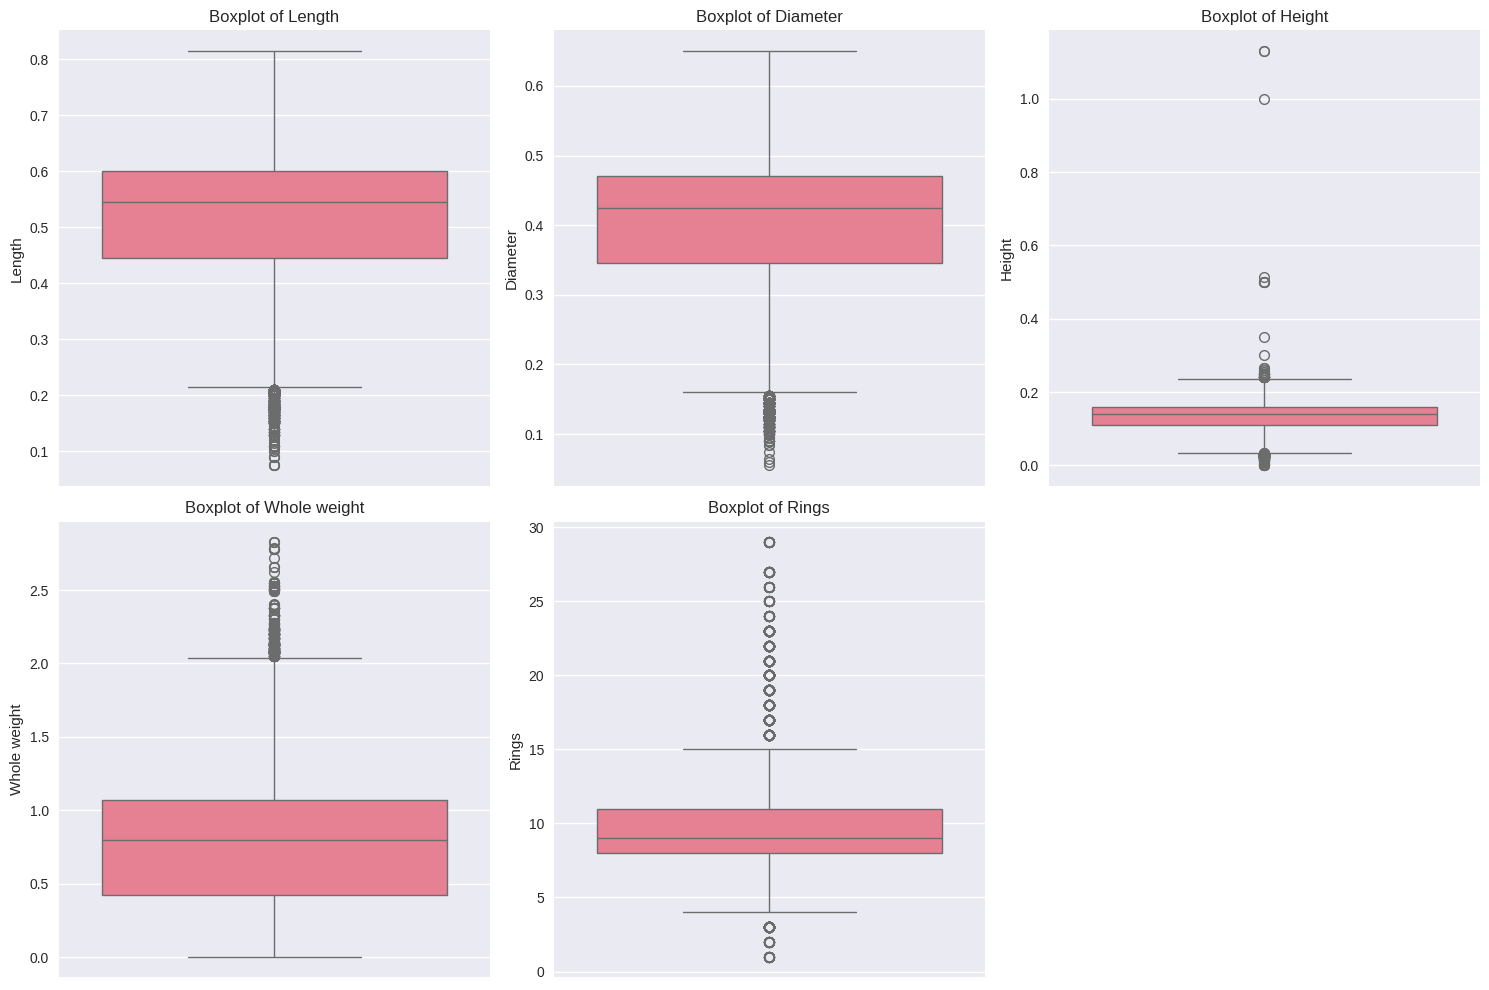

In [76]:
for col, stats in outlier_summary.items():
    print(f"{col}: {stats['count']} outliers ({stats['percentage']:.2f}% of data)")

plt.figure(figsize=(15, 10))
for i, column in enumerate(['Length', 'Diameter', 'Height', 'Whole weight', 'Rings']):
    if column in df.columns:
        plt.subplot(2, 3, i+1)
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.tight_layout()

plt.show()

In [77]:
def analyze_extreme_values(df, column):
    mean_val = df[column].mean()
    std_val = df[column].std()
    min_val = df[column].min()
    max_val = df[column].max()

    extreme_low = df[df[column] < (mean_val - 3 * std_val)]
    extreme_high = df[df[column] > (mean_val + 3 * std_val)]

    return {
        'mean': mean_val,
        'std': std_val,
        'min': min_val,
        'max': max_val,
        'extreme_low_count': len(extreme_low),
        'extreme_high_count': len(extreme_high),
        'extreme_percentage': ((len(extreme_low) + len(extreme_high)) / len(df)) * 100
    }

In [78]:
extreme_analysis = {}
for column in ['Length', 'Diameter', 'Height', 'Whole weight', 'Rings']:
    if column in df.columns:
        extreme_analysis[column] = analyze_extreme_values(df, column)

for col, stats in extreme_analysis.items():
    print(f"\n{col}:")
    print(f"  Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}")
    print(f"  Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")
    print(f"  Extreme low values: {stats['extreme_low_count']}")
    print(f"  Extreme high values: {stats['extreme_high_count']}")
    print(f"  Total extreme values: {stats['extreme_percentage']:.2f}% of data")


Length:
  Mean: 0.5171, Std: 0.1182
  Min: 0.0750, Max: 0.8150
  Extreme low values: 264
  Extreme high values: 0
  Total extreme values: 0.29% of data

Diameter:
  Mean: 0.4017, Std: 0.0980
  Min: 0.0550, Max: 0.6500
  Extreme low values: 116
  Extreme high values: 0
  Total extreme values: 0.13% of data

Height:
  Mean: 0.1355, Std: 0.0380
  Min: 0.0000, Max: 1.1300
  Extreme low values: 61
  Extreme high values: 31
  Total extreme values: 0.10% of data

Whole weight:
  Mean: 0.7890, Std: 0.4577
  Min: 0.0020, Max: 2.8255
  Extreme low values: 0
  Extreme high values: 289
  Total extreme values: 0.32% of data

Rings:
  Mean: 9.6968, Std: 3.1762
  Min: 1.0000, Max: 29.0000
  Extreme low values: 0
  Extreme high values: 1184
  Total extreme values: 1.31% of data


## 3. Data Preprocessing and Feature Engineering

In [79]:
df_processed = df.copy()

if 'id' in df_processed.columns:
    df_processed = df_processed.drop('id', axis=1)

print("Original columns:", df_processed.columns.tolist())

Original columns: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']


In [80]:
column_mapping = {
    'Whole weight': 'Whole_weight',
    'Whole weight.1': 'Shucked_weight',
    'Whole weight.2': 'Viscera_weight',
    'Shell weight': 'Shell_weight'
}

df_processed = df_processed.rename(columns=column_mapping)
print("Updated columns:", df_processed.columns.tolist())

Updated columns: ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']


In [81]:
def cap_outliers(df, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_limit = df[column].quantile(lower_percentile)
    upper_limit = df[column].quantile(upper_percentile)

    outliers_count = ((df[column] < lower_limit) | (df[column] > upper_limit)).sum()
    df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)
    return outliers_count

outlier_capping_summary = {}
for column in df_processed.select_dtypes(include=['number']).columns:
    if column != 'Sex' and column != 'Rings':
        outliers_capped = cap_outliers(df_processed, column)
        outlier_capping_summary[column] = outliers_capped

for col, count in outlier_capping_summary.items():
    print(f"{col}: {count} outliers capped")

df_processed.head()

Length: 1548 outliers capped
Diameter: 1645 outliers capped
Height: 1463 outliers capped
Whole_weight: 1808 outliers capped
Shucked_weight: 1715 outliers capped
Viscera_weight: 1596 outliers capped
Shell_weight: 1694 outliers capped


,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.190,0.135,0.045,0.0320,0.0125,0.0065,0.0100,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


 Create biologically and physically meaningful features that might help predict abalone age

In [82]:
df_processed['Age'] = df_processed['Rings'] + 1.5
df_processed['Volume'] = (4/3) * np.pi * df_processed['Length'] * df_processed['Diameter'] * df_processed['Height']
df_processed['Density'] = df_processed['Whole_weight'] / (df_processed['Volume'] + 1e-8)
df_processed['Shell_ratio'] = df_processed['Shell_weight'] / (df_processed['Whole_weight'] + 1e-8)
df_processed['Meat_ratio'] = df_processed['Shucked_weight'] / (df_processed['Whole_weight'] + 1e-8)
df_processed['BMI'] = df_processed['Whole_weight'] / (df_processed['Length']**2 + 1e-8)
df_processed['Surface_area'] = 2 * np.pi * ((df_processed['Length']*df_processed['Diameter'] + df_processed['Length']*df_processed['Height'] + df_processed['Diameter']*df_processed['Height'])/3)
df_processed['Viscera_Shell_ratio'] = df_processed['Viscera_weight'] / (df_processed['Shell_weight'] + 1e-8)
df_processed['Shucked_Viscera_ratio'] = df_processed['Shucked_weight'] / (df_processed['Viscera_weight'] + 1e-8)

Size and proportion factors

In [83]:
df_processed['Size_factor'] = df_processed['Length'] + df_processed['Diameter'] + df_processed['Height']
df_processed['Length_to_Diameter'] = df_processed['Length'] / (df_processed['Diameter'] + 1e-8)
df_processed['Height_to_Diameter'] = df_processed['Height'] / (df_processed['Diameter'] + 1e-8)

Log transformations to handle skewed distributions of weight features

In [84]:
df_processed['Log_Whole_weight'] = np.log1p(df_processed['Whole_weight'])
df_processed['Log_Shell_weight'] = np.log1p(df_processed['Shell_weight'])

In [85]:
print(f"Original dataset shape: {df.shape}")
print(f"Processed dataset shape: {df_processed.shape}")
print(f"Original features: {len(column_mapping) + 2}")
print(f"Engineered features added: {df_processed.shape[1] - len(column_mapping) - 2}")

Original dataset shape: (90615, 10)
Processed dataset shape: (90615, 23)
Original features: 6
Engineered features added: 17


In [86]:
print("\nSample of engineered features:")
new_features = ['Age', 'Volume', 'Density', 'Shell_ratio', 'Meat_ratio', 'BMI',
               'Surface_area', 'Viscera_Shell_ratio', 'Shucked_Viscera_ratio',
               'Size_factor', 'Length_to_Diameter', 'Height_to_Diameter',
               'Log_Whole_weight', 'Log_Shell_weight']

df_processed[new_features].head()


Sample of engineered features:


,Age,Volume,Density,Shell_ratio,Meat_ratio,BMI,Surface_area,Viscera_Shell_ratio,Shucked_Viscera_ratio,Size_factor,Length_to_Diameter,Height_to_Diameter,Log_Whole_weight,Log_Shell_weight
0,12.5,0.148597,5.191883,0.311082,0.425794,2.550413,0.803201,0.610417,2.242321,1.130,1.279070,0.348837,0.571827,0.215111
1,12.5,0.187497,6.026778,0.283186,0.405310,2.847065,0.986670,0.864062,1.656419,1.265,1.285714,0.295918,0.756122,0.277632
2,7.5,0.004835,6.618515,0.312500,0.390625,0.886426,0.084352,0.649999,1.923074,0.370,1.407407,0.333333,0.031499,0.009950
3,11.5,0.177579,5.149834,0.273373,0.410607,2.583151,0.928079,0.822000,1.827251,1.220,1.252632,0.315789,0.649456,0.223144
4,10.5,0.128444,6.088255,0.252558,0.472506,2.538755,0.760841,0.810127,2.309375,1.110,1.305882,0.305882,0.577736,0.180236


## 4. Exploratory Data Analysis (EDA)

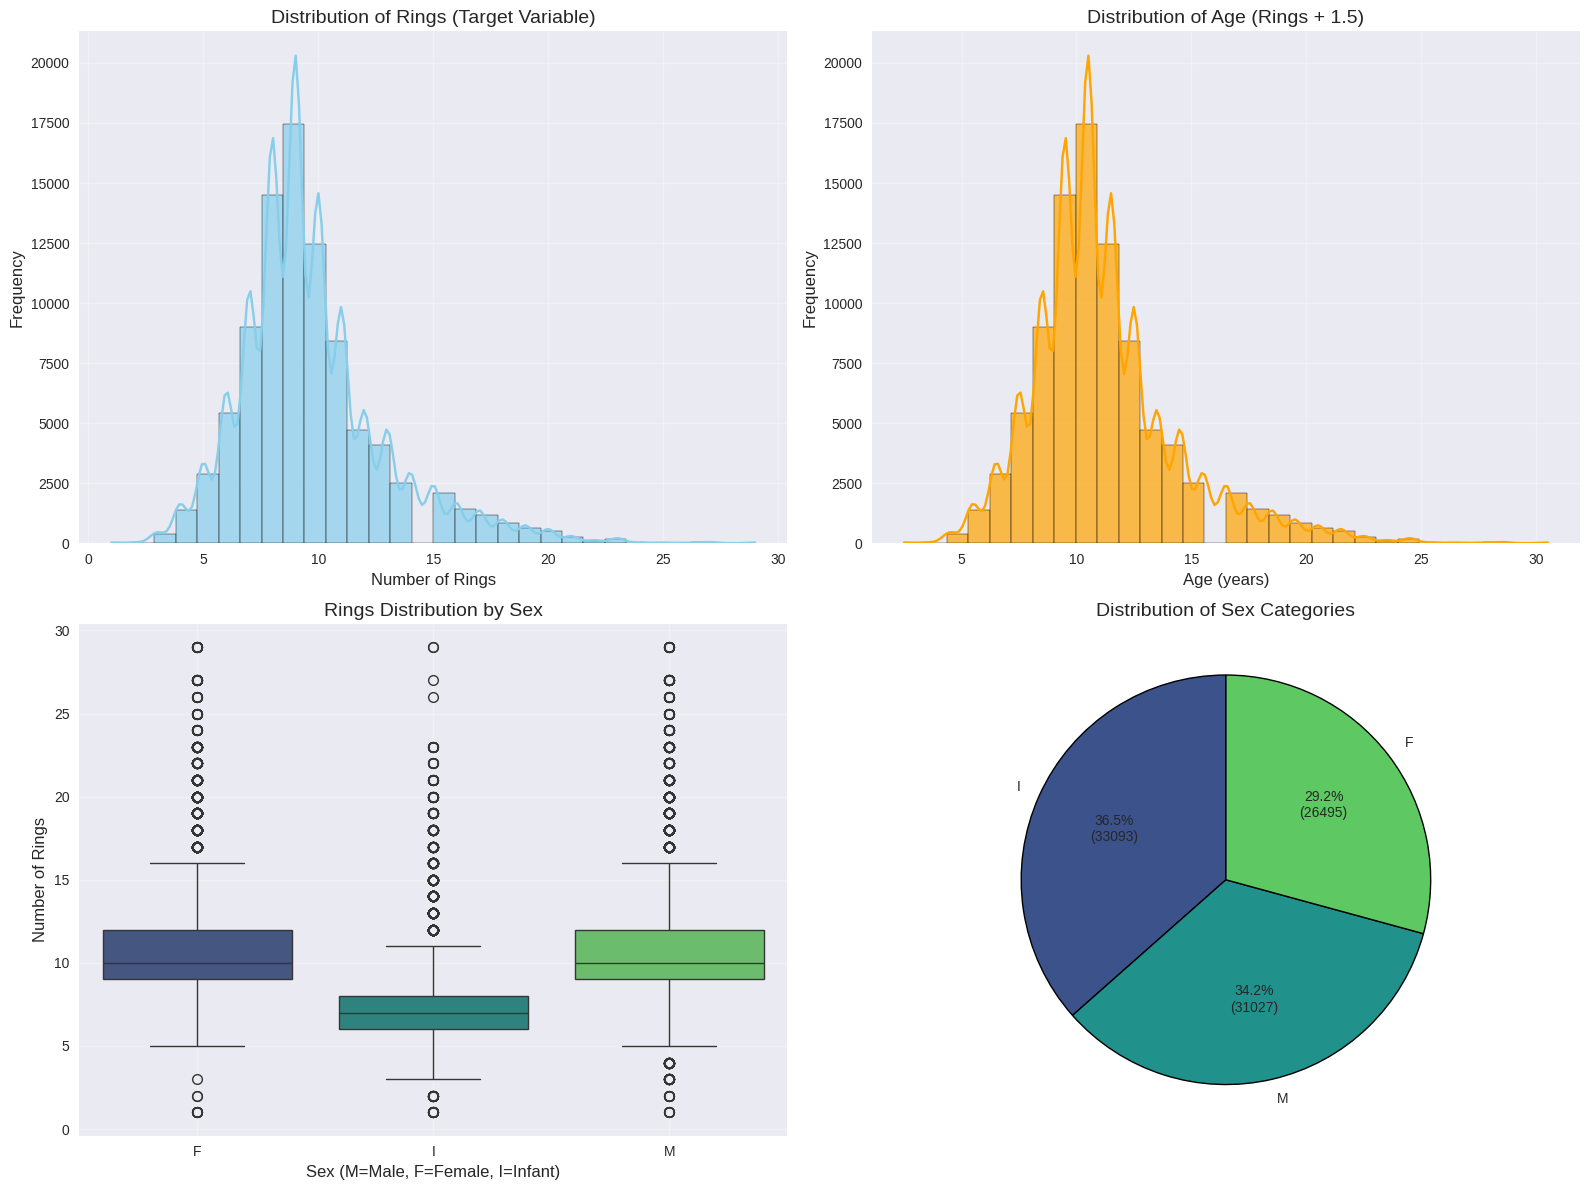

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(df_processed['Rings'], bins=30, kde=True, color='skyblue',
             edgecolor='black', alpha=0.7, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Rings (Target Variable)', fontsize=14)
axes[0, 0].set_xlabel('Number of Rings', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].grid(alpha=0.3)

sns.histplot(df_processed['Age'], bins=30, kde=True, color='orange',
             edgecolor='black', alpha=0.7, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Age (Rings + 1.5)', fontsize=14)
axes[0, 1].set_xlabel('Age (years)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].grid(alpha=0.3)

sns.boxplot(x='Sex', y='Rings', data=df_processed, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Rings Distribution by Sex', fontsize=14)
axes[1, 0].set_xlabel('Sex (M=Male, F=Female, I=Infant)', fontsize=12)
axes[1, 0].set_ylabel('Number of Rings', fontsize=12)
axes[1, 0].grid(alpha=0.3)

sex_counts = df_processed['Sex'].value_counts()
total = len(df_processed)
axes[1, 1].pie(sex_counts.values,
        labels=sex_counts.index,
        autopct=lambda p: f'{p:.1f}%\n({int(p*total/100)})',
        startangle=90,
        colors=sns.color_palette('viridis', 3),
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axes[1, 1].set_title('Distribution of Sex Categories', fontsize=14)

plt.tight_layout()
plt.show()

In [88]:
print("Target Variable Statistics:")
target_stats = df_processed['Rings'].describe()

print(f"Count:         {target_stats['count']:.0f}")
print(f"Mean:          {target_stats['mean']:.2f} rings")
print(f"Median:        {target_stats['50%']:.2f} rings")
print(f"Std Deviation: {target_stats['std']:.2f} rings")
print(f"Minimum:       {target_stats['min']:.0f} rings")
print(f"Maximum:       {target_stats['max']:.0f} rings")

print("\nAge Statistics (Rings + 1.5 years):")
print("=" * 40)
age_stats = df_processed['Age'].describe()
print(f"Mean Age:      {age_stats['mean']:.2f} years")
print(f"Median Age:    {age_stats['50%']:.2f} years")
print(f"Min Age:       {age_stats['min']:.1f} years")
print(f"Max Age:       {age_stats['max']:.1f} years")

print("\nAge Statistics by Sex:")
print("=" * 40)
sex_age_stats = df_processed.groupby('Sex')['Age'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
print(sex_age_stats)

Target Variable Statistics:
Count:         90615
Mean:          9.70 rings
Median:        9.00 rings
Std Deviation: 3.18 rings
Minimum:       1 rings
Maximum:       29 rings

Age Statistics (Rings + 1.5 years):
Mean Age:      11.20 years
Median Age:    10.50 years
Min Age:       2.5 years
Max Age:       30.5 years

Age Statistics by Sex:
      mean  median  min   max   std
Sex                                
F    12.66    11.5  2.5  30.5  3.02
I     9.03     8.5  2.5  30.5  2.13
M    12.25    11.5  2.5  30.5  2.98


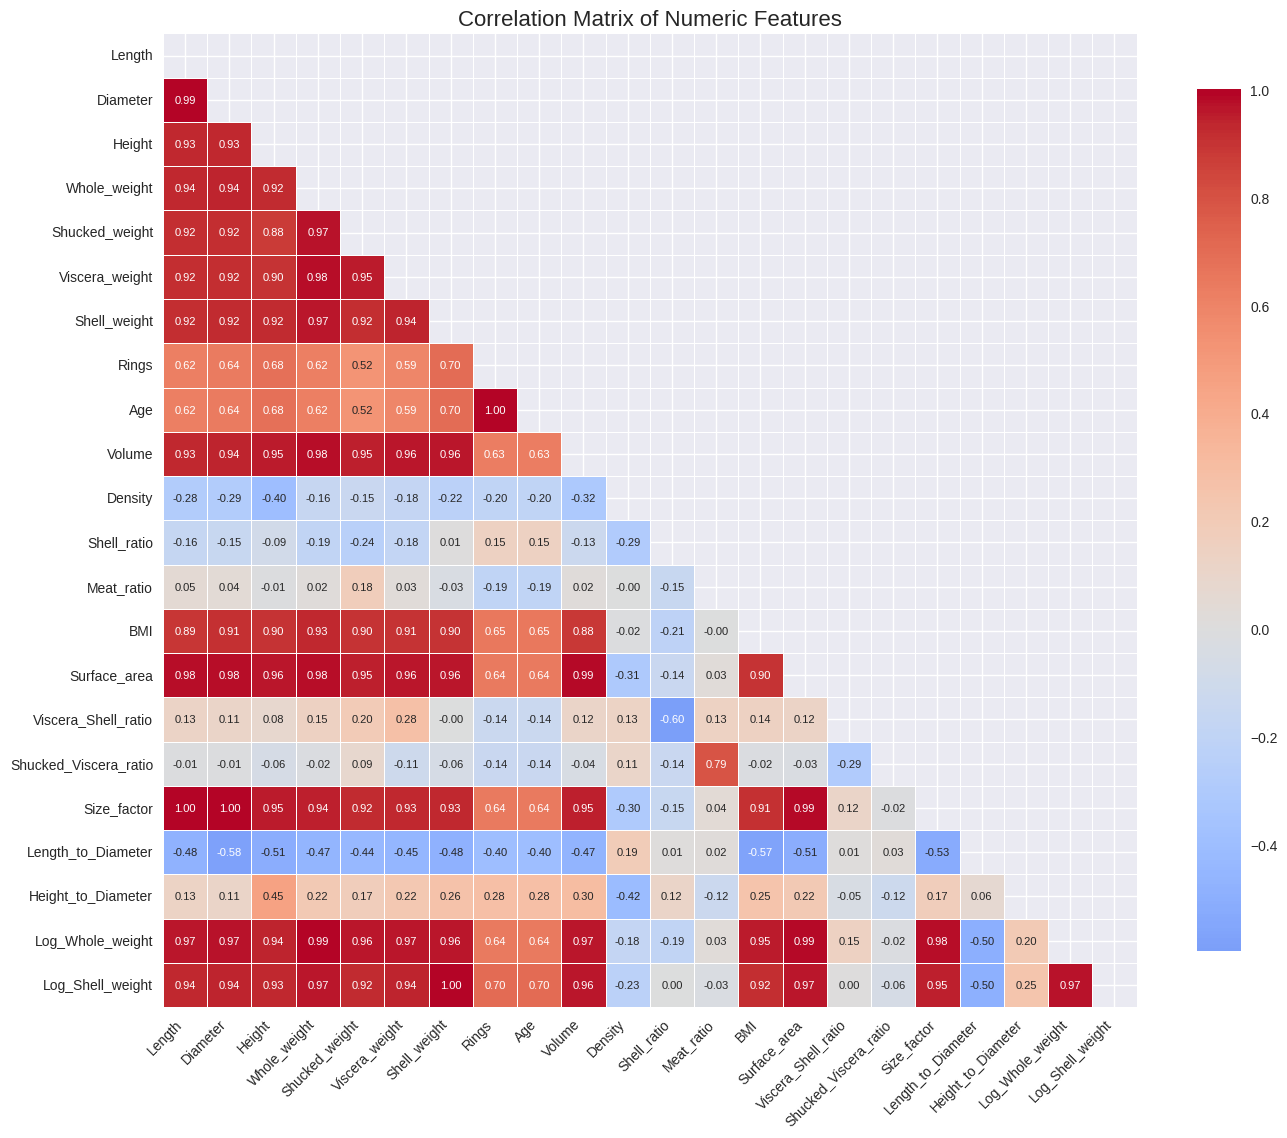

In [89]:
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
corr_matrix = df_processed[numeric_cols].corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8},
            linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Correlation with Rings (Target Variable):
Log_Shell_weight     +0.7017 (Very Strong)
Shell_weight         +0.6965 (Strong)
Height               +0.6755 (Strong)
BMI                  +0.6514 (Strong)
Size_factor          +0.6437 (Strong)
Log_Whole_weight     +0.6432 (Strong)
Surface_area         +0.6395 (Strong)
Diameter             +0.6372 (Strong)
Volume               +0.6280 (Strong)
Length               +0.6244 (Strong)
Whole_weight         +0.6210 (Strong)
Viscera_weight       +0.5927 (Strong)
Shucked_weight       +0.5204 (Strong)
Height_to_Diameter   +0.2826 (Weak)
Shell_ratio          +0.1463 (Weak)
Viscera_Shell_ratio  -0.1365 (Weak)
Shucked_Viscera_ratio -0.1428 (Weak)
Meat_ratio           -0.1943 (Weak)
Density              -0.1998 (Weak)
Length_to_Diameter   -0.4005 (Moderate)


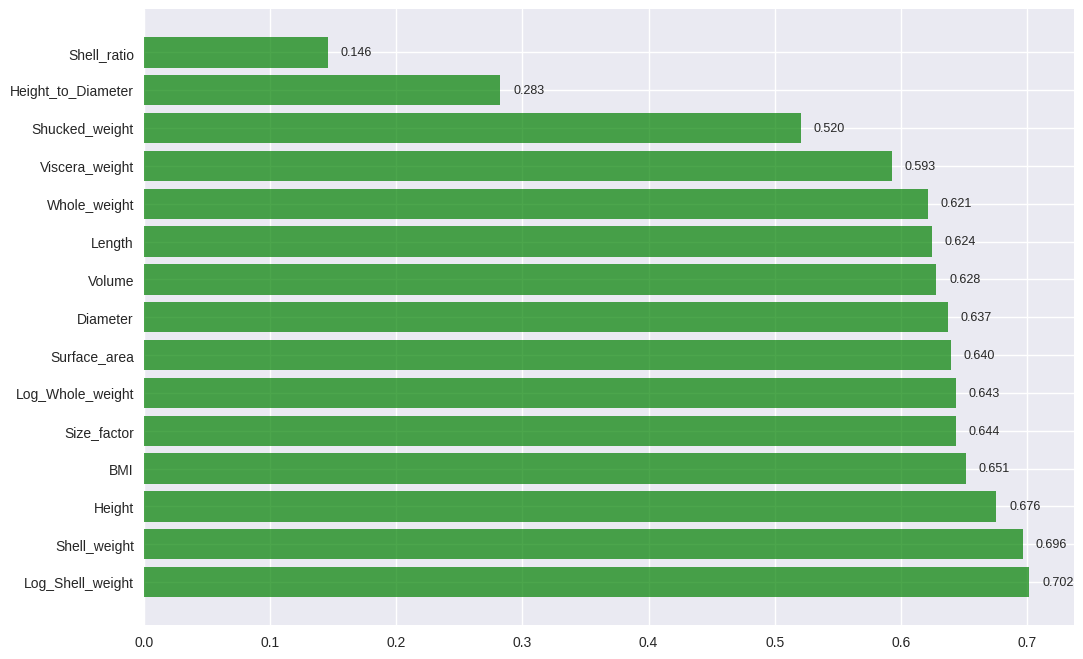

In [90]:
print("Correlation with Rings (Target Variable):")
target_corr = corr_matrix['Rings'].sort_values(ascending=False)

for feature, corr_value in target_corr.items():
    if feature != 'Rings' and feature != 'Age':
        strength = ""
        if abs(corr_value) > 0.7:
            strength = "(Very Strong)"
        elif abs(corr_value) > 0.5:
            strength = "(Strong)"
        elif abs(corr_value) > 0.3:
            strength = "(Moderate)"
        elif abs(corr_value) > 0.1:
            strength = "(Weak)"
        else:
            strength = "(Very Weak)"
        print(f"{feature:20} {corr_value:+.4f} {strength}")

plt.figure(figsize=(12, 8))
target_corr_filtered = target_corr[~target_corr.index.isin(['Rings', 'Age'])].head(15)

colors = ['red' if x < 0 else 'green' for x in target_corr_filtered.values]

target_corr_filtered = target_corr_filtered.reindex(
    target_corr_filtered.abs().sort_values(ascending=False).index)

bars = plt.barh(target_corr_filtered.index, target_corr_filtered.values, color=colors, alpha=0.7)

for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.01 if width > 0 else width - 0.07
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=9)

## 5. Model Preparation and Training

In [92]:
df_model = df_processed.copy()

le = LabelEncoder()
df_model['Sex_encoded'] = le.fit_transform(df_model['Sex'])
base_features = ['Sex_encoded', 'Length', 'Diameter', 'Height',
                'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

engineered_features = ['Volume', 'Density', 'Shell_ratio', 'Meat_ratio', 'BMI',
                      'Surface_area', 'Shucked_Viscera_ratio']

feature_columns = base_features + engineered_features

X = df_model[feature_columns]
y = df_model['Rings']

print(f"Selected {len(feature_columns)} features for modeling:")
for i, feature in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feature}")

Selected 15 features for modeling:
   1. Sex_encoded
   2. Length
   3. Diameter
   4. Height
   5. Whole_weight
   6. Shucked_weight
   7. Viscera_weight
   8. Shell_weight
   9. Volume
  10. Density
  11. Shell_ratio
  12. Meat_ratio
  13. BMI
  14. Surface_area
  15. Shucked_Viscera_ratio


In [93]:
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

missing_features = X.isnull().sum()
missing_target = y.isnull().sum()

Features shape: (90615, 15)
Target shape: (90615,)


In [94]:
print(f"Missing values in features: {missing_features.sum()}")
if missing_features.sum() > 0:
    print(missing_features[missing_features > 0])

Missing values in features: 0


In [95]:
print(f"Missing values in target: {missing_target}")
X.describe().round(3)

Missing values in target: 0


,Sex_encoded,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Volume,Density,Shell_ratio,Meat_ratio,BMI,Surface_area,Shucked_Viscera_ratio
count,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000,90615.000
mean,1.050,0.517,0.402,0.135,0.787,0.340,0.169,0.225,0.137,5.877,0.291,0.431,2.554,0.735,2.044
std,0.795,0.117,0.097,0.037,0.452,0.201,0.100,0.128,0.081,0.762,0.044,0.076,0.693,0.310,0.518
min,0.000,0.190,0.135,0.045,0.032,0.012,0.006,0.010,0.005,2.138,0.090,0.154,0.439,0.084,0.568
25%,0.000,0.445,0.345,0.110,0.419,0.178,0.086,0.120,0.071,5.394,0.265,0.397,2.083,0.505,1.793
50%,1.000,0.545,0.425,0.140,0.800,0.330,0.166,0.225,0.135,5.807,0.287,0.431,2.630,0.767,2.013
75%,2.000,0.600,0.470,0.160,1.068,0.463,0.232,0.305,0.187,6.272,0.312,0.464,3.034,0.946,2.246
max,2.000,0.720,0.570,0.215,1.938,0.897,0.422,0.570,0.370,18.485,2.616,4.783,12.867,1.440,33.000


In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=None
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/X.shape[0]:.1%})")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/X.shape[0]:.1%})")

Training set: 72492 samples (80.0%)
Test set: 18123 samples (20.0%)


In [97]:
print("Performing feature scaling (standardization)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling statistics:")
print(f"  Mean before scaling (first 3 features): {X_train.iloc[:, :3].mean().values}")
print(f"  Std before scaling (first 3 features): {X_train.iloc[:, :3].std().values}")
print(f"  Mean after scaling (first 3 features): {X_train_scaled[:, :3].mean(axis=0)}")
print(f"  Std after scaling (first 3 features): {X_train_scaled[:, :3].std(axis=0)}")

Performing feature scaling (standardization)...
Scaling statistics:
  Mean before scaling (first 3 features): [1.04823981 0.51718674 0.40169372]
  Std before scaling (first 3 features): [0.79564333 0.11716425 0.09731757]
  Mean after scaling (first 3 features): [8.60586716e-17 7.84133682e-19 3.22376960e-16]
  Std after scaling (first 3 features): [1. 1. 1.]


In [98]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [99]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    results = {
        'Model': model_name,
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'CV_R2_Mean': cv_scores.mean(),
        'CV_R2_Std': cv_scores.std()
    }

    return results, y_test_pred

In [100]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0)
}

results_list = []
predictions_dict = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")

    model.fit(X_train_scaled, y_train)
    results, y_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)

    results_list.append(results)
    predictions_dict[model_name] = y_pred

    print(f"  - Test R²: {results['Test_R2']:.4f}")
    print(f"  - Test RMSE: {results['Test_RMSE']:.4f}")
    print(f"  - CV R² Mean: {results['CV_R2_Mean']:.4f} (±{results['CV_R2_Std']:.4f})")

Training Linear Regression...
  - Test R²: 0.6147
  - Test RMSE: 1.9893
  - CV R² Mean: 0.6241 (±0.0031)
Training Ridge Regression...
  - Test R²: 0.6147
  - Test RMSE: 1.9894
  - CV R² Mean: 0.6241 (±0.0031)
Training Lasso Regression...
  - Test R²: 0.3831
  - Test RMSE: 2.5174
  - CV R² Mean: 0.3905 (±0.0052)
Training Random Forest...
  - Test R²: 0.6474
  - Test RMSE: 1.9031
  - CV R² Mean: 0.6453 (±0.0013)
Training Gradient Boosting...
  - Test R²: 0.6479
  - Test RMSE: 1.9019
  - CV R² Mean: 0.6539 (±0.0023)
Training Support Vector Regression...
  - Test R²: 0.6333
  - Test RMSE: 1.9409
  - CV R² Mean: 0.6396 (±0.0034)


In [101]:
results_df = pd.DataFrame(results_list)
print("Model Performance Summary:")
print(results_df.round(4))

Model Performance Summary:
                       Model  Train_MSE  Test_MSE  Train_RMSE  Test_RMSE  \
0          Linear Regression     3.7711    3.9575      1.9419     1.9893   
1           Ridge Regression     3.7711    3.9578      1.9419     1.9894   
2           Lasso Regression     6.1203    6.3373      2.4739     2.5174   
3              Random Forest     0.5056    3.6216      0.7111     1.9031   
4          Gradient Boosting     3.3866    3.6171      1.8403     1.9019   
5  Support Vector Regression     3.5769    3.7671      1.8913     1.9409   

   Train_MAE  Test_MAE  Train_R2  Test_R2  CV_R2_Mean  CV_R2_Std  
0     1.3466    1.3784    0.6245   0.6147      0.6241     0.0031  
1     1.3466    1.3784    0.6245   0.6147      0.6241     0.0031  
2     1.7389    1.7665    0.3905   0.3831      0.3905     0.0052  
3     0.4784    1.2980    0.9497   0.6474      0.6453     0.0013  
4     1.2458    1.2832    0.6628   0.6479      0.6539     0.0023  
5     1.2201    1.2539    0.6438   0.6

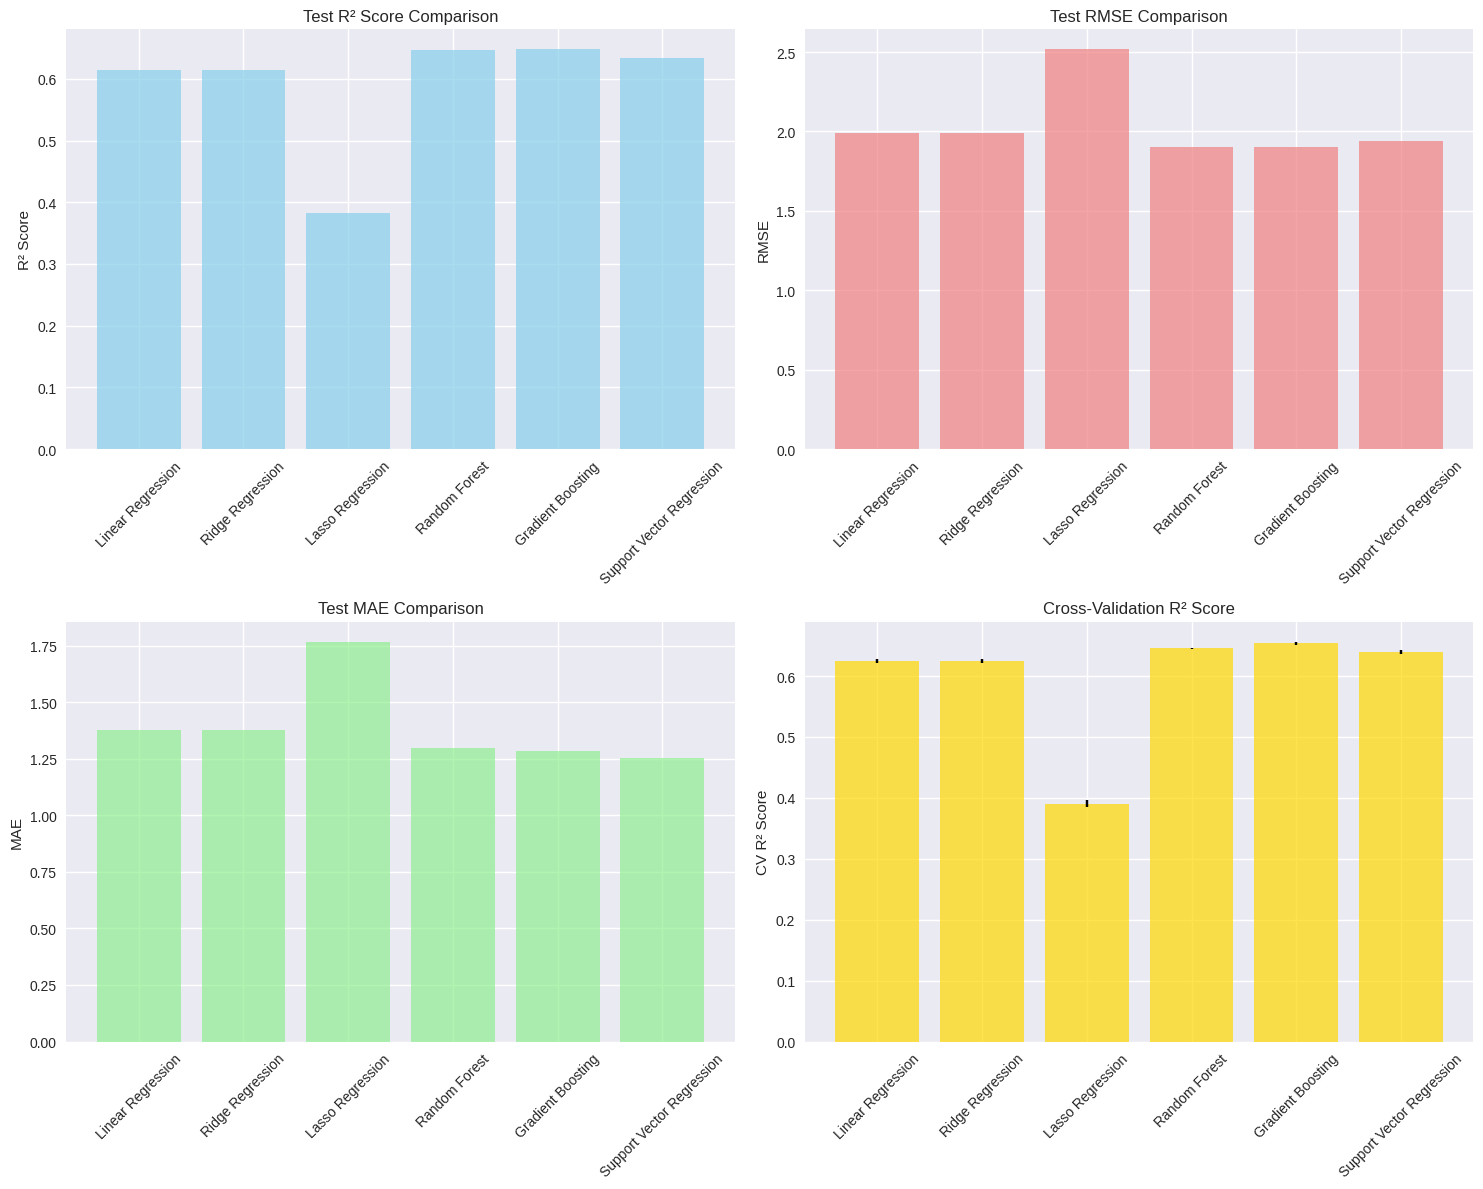

In [102]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].bar(results_df['Model'], results_df['Test_R2'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Test R² Score Comparison')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)

axes[0, 1].bar(results_df['Model'], results_df['Test_RMSE'], color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Test RMSE Comparison')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].tick_params(axis='x', rotation=45)

axes[1, 0].bar(results_df['Model'], results_df['Test_MAE'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Test MAE Comparison')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].tick_params(axis='x', rotation=45)

axes[1, 1].bar(results_df['Model'], results_df['CV_R2_Mean'],
               yerr=results_df['CV_R2_Std'], color='gold', alpha=0.7, capsize=5)
axes[1, 1].set_title('Cross-Validation R² Score')
axes[1, 1].set_ylabel('CV R² Score')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [103]:
best_model_idx = results_df['Test_R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2_score = results_df.loc[best_model_idx, 'Test_R2']

print(f"Best performing model: {best_model_name}")
print(f"Best Test R² Score: {best_r2_score:.4f}")

Best performing model: Gradient Boosting
Best Test R² Score: 0.6479


## 6. Hyperparameter Tuning for Best Model

In [108]:
print("Tuning Gradient Boosting...")
gb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_scaled, y_train)
print(f"Best GB parameters: {gb_grid.best_params_}")
print(f"Best GB cross-validation score: {gb_grid.best_score_:.4f}")

Tuning Gradient Boosting...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best GB parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best GB cross-validation score: 0.6585


In [109]:
tuned_models = {
    'Tuned Gradient Boosting': gb_grid.best_estimator_
}

tuned_results = []
tuned_predictions = {}

for model_name, model in tuned_models.items():
    results, y_pred = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, model_name)
    tuned_results.append(results)
    tuned_predictions[model_name] = y_pred

    print(f"{model_name}:")
    print(f"  - Test R²: {results['Test_R2']:.4f}")
    print(f"  - Test RMSE: {results['Test_RMSE']:.4f}")
    print(f"  - CV R² Mean: {results['CV_R2_Mean']:.4f} (±{results['CV_R2_Std']:.4f})")

Tuned Gradient Boosting:
  - Test R²: 0.6557
  - Test RMSE: 1.8806
  - CV R² Mean: 0.6585 (±0.0011)


In [110]:
all_results = results_list + tuned_results
all_results_df = pd.DataFrame(all_results)

print("All Models Performance Comparison:")
print(all_results_df.sort_values('Test_R2', ascending=False)[['Model', 'Test_R2', 'Test_RMSE', 'CV_R2_Mean']].round(4))

final_best_idx = all_results_df['Test_R2'].idxmax()
final_best_model_name = all_results_df.loc[final_best_idx, 'Model']
final_best_r2 = all_results_df.loc[final_best_idx, 'Test_R2']

All Models Performance Comparison:
                       Model  Test_R2  Test_RMSE  CV_R2_Mean
6    Tuned Gradient Boosting   0.6557     1.8806      0.6585
4          Gradient Boosting   0.6479     1.9019      0.6539
3              Random Forest   0.6474     1.9031      0.6453
5  Support Vector Regression   0.6333     1.9409      0.6396
0          Linear Regression   0.6147     1.9893      0.6241
1           Ridge Regression   0.6147     1.9894      0.6241
2           Lasso Regression   0.3831     2.5174      0.3905


In [111]:
print(f"Final best model: {final_best_model_name}")
print(f"Final best R² score: {final_best_r2:.4f}")

if 'Tuned' in final_best_model_name:
    final_best_model = gb_grid.best_estimator_
else:
    final_best_model = models[final_best_model_name]

Final best model: Tuned Gradient Boosting
Final best R² score: 0.6557


## 7. Model Analysis and Interpretation

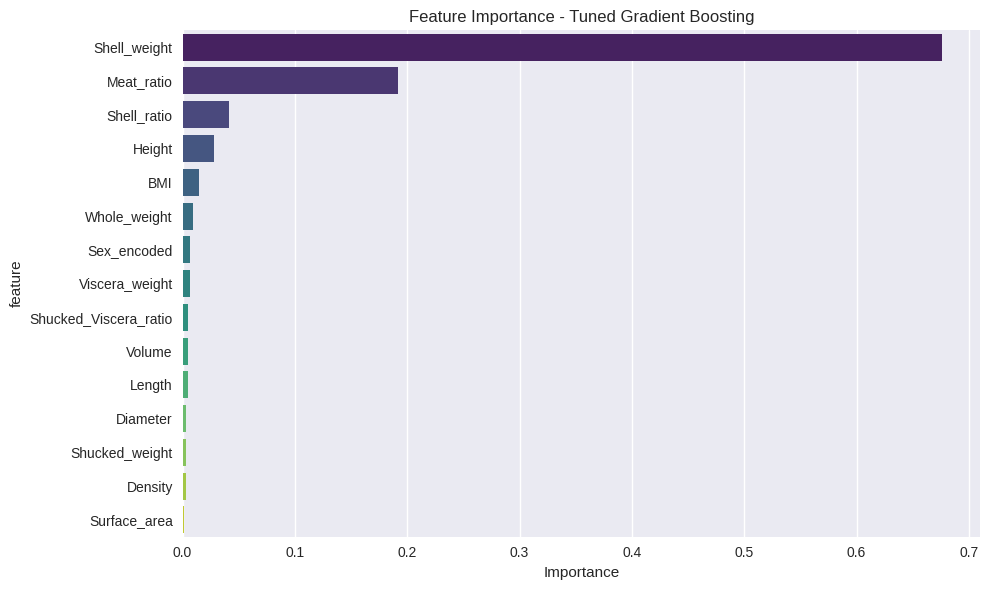

Top 5 Most Important Features:
         feature  importance
7   Shell_weight    0.676031
11    Meat_ratio    0.191553
10   Shell_ratio    0.040958
3         Height    0.028283
12           BMI    0.015102


In [112]:
if hasattr(final_best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': final_best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
    plt.title(f'Feature Importance - {final_best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

    print("Top 5 Most Important Features:")
    print(feature_importance.head())
else:
    print("Selected model doesn't provide feature importance scores.")

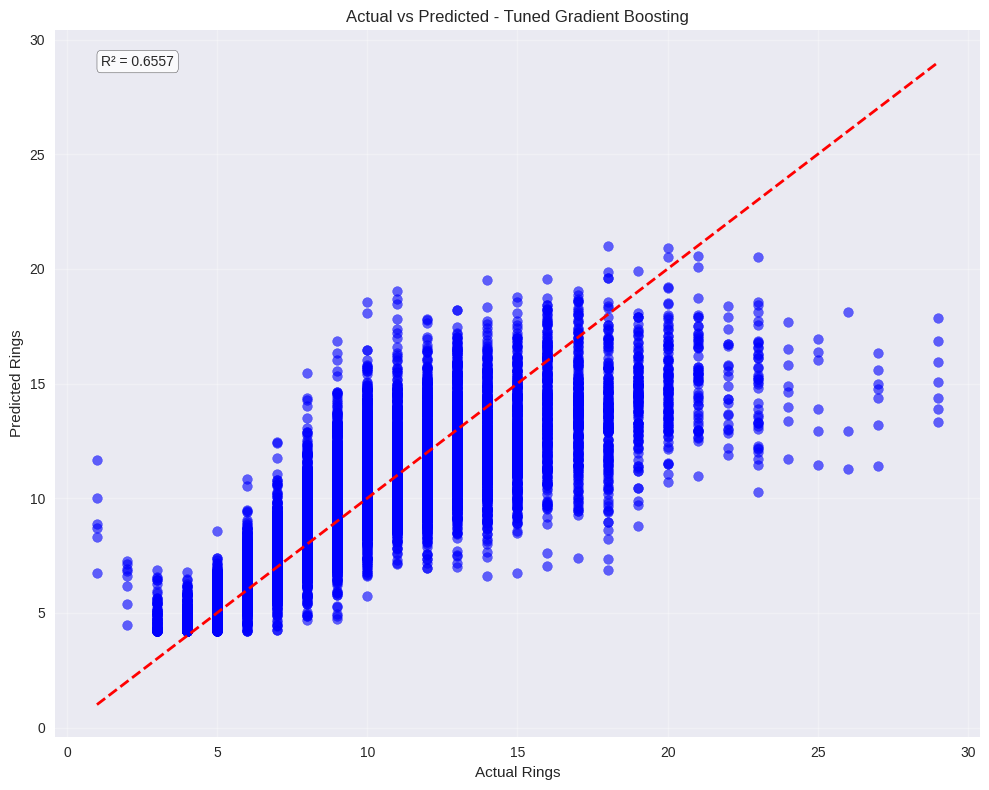

In [113]:
plt.figure(figsize=(10, 8))
y_pred_final = final_best_model.predict(X_test_scaled)

plt.scatter(y_test, y_pred_final, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rings')
plt.ylabel('Predicted Rings')
plt.title(f'Actual vs Predicted - {final_best_model_name}')
plt.grid(True, alpha=0.3)

r2_final = r2_score(y_test, y_pred_final)
plt.text(0.05, 0.95, f'R² = {r2_final:.4f}', transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [114]:
models_dir = './models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Created directory: {models_dir}")

def save_artifact(artifact, filename, description):
    try:
        joblib.dump(artifact, filename)
        print(f"{description} saved to: {filename}")
        return True
    except Exception as e:
        print(f"Error saving {description}: {e}")
        return False

Created directory: ./models


In [115]:
model_path = f'{models_dir}/best_abalone_model.pkl'
scaler_path = f'{models_dir}/scaler.pkl'
le_path = f'{models_dir}/label_encoder.pkl'
feature_cols_path = f'{models_dir}/feature_columns.pkl'
metadata_path = f'{models_dir}/model_metadata.pkl'

save_artifact(final_best_model, model_path, "Best model")
save_artifact(scaler, scaler_path, "Scaler")
save_artifact(le, le_path, "Label encoder")
save_artifact(feature_columns, feature_cols_path, "Feature columns")

model_metadata = {
    'model_name': final_best_model_name,
    'model_type': type(final_best_model).__name__,
    'test_r2_score': final_best_r2,
    'test_rmse': np.sqrt(mean_squared_error(y_test, final_best_model.predict(X_test_scaled))),
    'test_mae': mean_absolute_error(y_test, final_best_model.predict(X_test_scaled)),
    'feature_columns': feature_columns,
    'target_column': 'Rings',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_shape': df.shape,
    'scaling_method': 'StandardScaler',
    'categorical_encoding': 'LabelEncoder',
    'best_params': gb_grid.best_params_
}

save_artifact(model_metadata, metadata_path, "Model metadata")

print(f"Final model: {final_best_model_name}")
print(f"Performance: R² = {final_best_r2:.4f}")
print(f"All artifacts saved to: {models_dir}/")

Best model saved to: ./models/best_abalone_model.pkl
Scaler saved to: ./models/scaler.pkl
Label encoder saved to: ./models/label_encoder.pkl
Feature columns saved to: ./models/feature_columns.pkl
Model metadata saved to: ./models/model_metadata.pkl
Final model: Tuned Gradient Boosting
Performance: R² = 0.6557
All artifacts saved to: ./models/
